# 1. EDA

In [1]:
import pandas as pd
from tqdm import tqdm
tqdm.pandas()

In [2]:
df = pd.read_csv("data/orig/train.csv")
print(len(df))
df.head(2)

300000


,id,raw_address,POI/street
0,0,kedai kopi sidikalang palapa no 8 labuh baru t...,kedai kopi sidikalang/palapa
1,1,"jalan b. kawi, no 18 rw 11 50261",/jalan b. kawi


In [3]:
df[["poi", "street"]] = df["POI/street"].str.split("/", expand=True)
df.head(2)

,id,raw_address,POI/street,poi,street
0,0,kedai kopi sidikalang palapa no 8 labuh baru t...,kedai kopi sidikalang/palapa,kedai kopi sidikalang,palapa
1,1,"jalan b. kawi, no 18 rw 11 50261",/jalan b. kawi,,jalan b. kawi


## 1.1 Distributions

<AxesSubplot:>

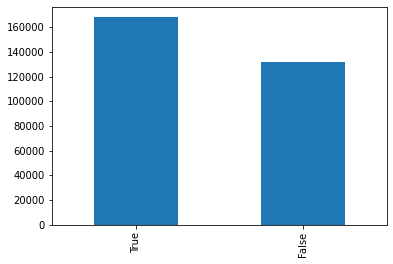

In [4]:
(df["poi"] == "").value_counts().plot(kind="bar")

<AxesSubplot:>

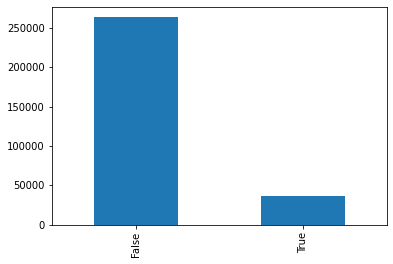

In [5]:
(df["street"] == "").value_counts().plot(kind="bar")

<AxesSubplot:>

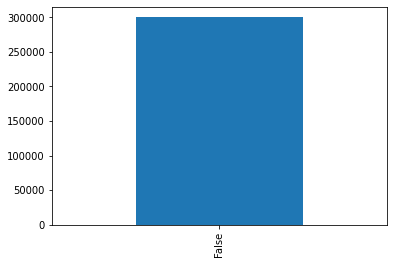

In [6]:
(df["POI/street"] == "").value_counts().plot(kind="bar")

### Observations:

1. A large proportion (~60%) of the text don't have person names.
2. Most of the text (~80%) have address information.
3. All text have either person name or address info or both.

## 1.2 See whether this problem can be modelled as span-based problem

In [7]:
import re
import json

from transformers import AutoTokenizer, AutoModelForTokenClassification
tokenizer = AutoTokenizer.from_pretrained("cahya/xlm-roberta-large-indonesian-NER")
patt = re.compile("((?<=.)(?![a-zA-Z0-9]))|((?<![a-zA-Z0-9])(?<=.)(?=.))")

In [8]:
def pre_tokenize(s):
    """Split punctuations, etc."""
    s_tokenized = patt.split(s)
    s_tokenized = list(
        filter(lambda x: x is not None and len(x) > 0 and not x.isspace(), 
               s_tokenized)
    )
    s = " ".join(s_tokenized)
    return s

def transforms(row):
    raw_address, poi, street = row[["raw_address", "poi", "street"]]

    raw_address_tokenized = tokenizer.tokenize(pre_tokenize(raw_address))
    poi_tokenized = tokenizer.tokenize(pre_tokenize(poi))
    street_tokenized = tokenizer.tokenize(pre_tokenize(street))

    # Get the start and end indices of each of [POI, street] in the raw address
    poi_start, poi_end, street_start, street_end = -1, -1, -1, -1

    if len(poi_tokenized) > 0:
        for i, raw_address_i in enumerate(raw_address_tokenized):
            if raw_address_i == poi_tokenized[0]:
                for j in range(1, len(poi_tokenized)):
                    if i + j >= len(raw_address_tokenized):
                        break
                    if raw_address_tokenized[i + j] != poi_tokenized[j]:
                        break
                else:
                    poi_start = i
                    poi_end = i + len(poi_tokenized) - 1
                    break

        if poi_start == -1 or poi_end == -1:
            raise ValueError(f"POI not found. ID: {row['id']}, raw address: {raw_address_tokenized}, POI: {poi_tokenized}")

    if len(street_tokenized) > 0:
        for i, raw_address_i in enumerate(raw_address_tokenized):
            if raw_address_i == street_tokenized[0]:
                for j in range(1, len(street_tokenized)):
                    if i + j >= len(raw_address_tokenized):
                        break
                    if raw_address_tokenized[i + j] != street_tokenized[j]:
                        break
                else:
                    street_start = i
                    street_end = i + len(street_tokenized) - 1
                    break

        if street_start == -1 or street_end == -1:
            raise ValueError(f"Street not found. ID:{row['id']}, raw address: {raw_address_tokenized}, street: {street_tokenized}")

    return pd.Series({"raw_address": raw_address, "poi": poi, "street": street,
                      "raw_address_tok": raw_address_tokenized, 
                      "poi_tok": poi_tokenized, "street_tok": street_tokenized,
                      "poi_start": poi_start, "poi_end": poi_end, 
                      "street_start": street_start, "street_end": street_end})

In [9]:
df_processed = df.progress_apply(transforms, axis=1)
print(len(df_processed))
df_processed.head(2)

100%|██████████| 300000/300000 [04:20<00:00, 1153.76it/s]

300000


,raw_address,poi,street,raw_address_tok,poi_tok,street_tok,poi_start,poi_end,street_start,street_end
0,kedai kopi sidikalang palapa no 8 labuh baru t...,kedai kopi sidikalang,palapa,"[▁kedai, ▁kopi, ▁si, dika, lang, ▁pala, pa, ▁n...","[▁kedai, ▁kopi, ▁si, dika, lang]","[▁pala, pa]",0,4,5,6
1,"jalan b. kawi, no 18 rw 11 50261",,jalan b. kawi,"[▁jalan, ▁b, ▁, ., ▁ka, wi, ▁, ,, ▁no, ▁18, ▁r...",[],"[▁jalan, ▁b, ▁, ., ▁ka, wi]",-1,-1,0,5


In [10]:
df_processed = df_processed.T.to_dict()
print(len(df_processed))
df_processed[0]

300000


{'raw_address': 'kedai kopi sidikalang palapa no 8 labuh baru timur',
 'poi': 'kedai kopi sidikalang',
 'street': 'palapa',
 'raw_address_tok': ['▁kedai',
  '▁kopi',
  '▁si',
  'dika',
  'lang',
  '▁pala',
  'pa',
  '▁no',
  '▁8',
  '▁la',
  'buh',
  '▁baru',
  '▁timur'],
 'poi_tok': ['▁kedai', '▁kopi', '▁si', 'dika', 'lang'],
 'street_tok': ['▁pala', 'pa'],
 'poi_start': 0,
 'poi_end': 4,
 'street_start': 5,
 'street_end': 6}

In [11]:
with open("data/processed/train_processed.json", "w") as fout:
    json.dump(df_processed, fout, indent=2)

# 2. EDA (con't)

In [1]:
import json

import pandas as pd

In [2]:
with open("data/processed/train_processed.json", "r") as fin:
    df = json.load(fin)

df = pd.DataFrame.from_dict(df, orient="index")
print(len(df))
df.head(3)

300000


,raw_address,poi,street,raw_address_tok,poi_tok,street_tok,poi_start,poi_end,street_start,street_end
0,kedai kopi sidikalang palapa no 8 labuh baru t...,kedai kopi sidikalang,palapa,"[▁kedai, ▁kopi, ▁si, dika, lang, ▁pala, pa, ▁n...","[▁kedai, ▁kopi, ▁si, dika, lang]","[▁pala, pa]",0,4,5,6
1,"jalan b. kawi, no 18 rw 11 50261",,jalan b. kawi,"[▁jalan, ▁b, ▁, ., ▁ka, wi, ▁, ,, ▁no, ▁18, ▁r...",[],"[▁jalan, ▁b, ▁, ., ▁ka, wi]",-1,-1,0,5
2,"jalan gajah mada, no 20x",,jalan gajah mada,"[▁jalan, ▁ga, jah, ▁mada, ▁, ,, ▁no, ▁20, x]",[],"[▁jalan, ▁ga, jah, ▁mada]",-1,-1,0,3


## 2.1 Length distribution

<AxesSubplot:>

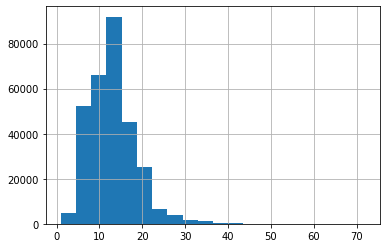

In [16]:
df["raw_address_tok"].apply(len).hist(bins=20)

<AxesSubplot:>

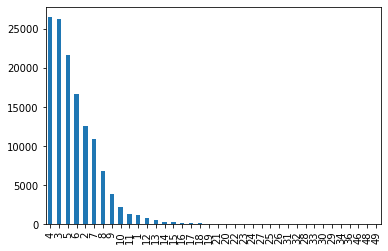

In [4]:
lengths = df["poi_tok"].apply(len)
lengths = lengths[lengths > 0]
lengths.value_counts().plot(kind="bar")

In [5]:
lengths.value_counts().tail()

34    1
36    1
46    1
48    1
49    1
Name: poi_tok, dtype: int64

<AxesSubplot:>

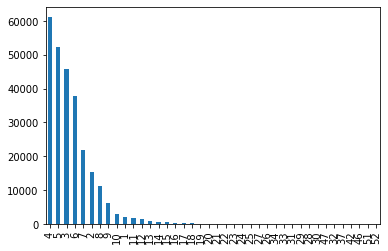

In [6]:
lengths = df["street_tok"].apply(len)
lengths = lengths[lengths > 0]
lengths.value_counts().plot(kind="bar")

In [7]:
lengths.value_counts().tail()

37    1
42    1
46    1
51    1
52    1
Name: street_tok, dtype: int64

### Observations

1. Most of POI/street has length of 3 - 5 (tokenized).
2. The two distributions (street and POI) are similar.
3. There are quite a few of outliers (e.g., length of 49 for POI and length of 52 for street).

## 2.2 Normalized length distribution

<AxesSubplot:>

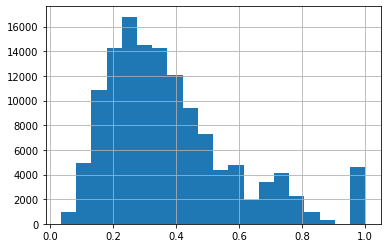

In [8]:
lengths = df["poi_tok"].apply(len)
s_lengths = df["raw_address_tok"].apply(len)

mask = lengths > 0
lengths = lengths[mask]
s_lengths = s_lengths[mask]

(lengths / s_lengths).hist(bins=20)

<AxesSubplot:>

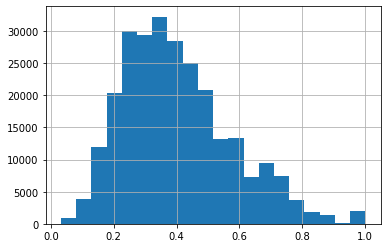

In [9]:
lengths = df["street_tok"].apply(len)
s_lengths = df["raw_address_tok"].apply(len)

mask = lengths > 0
lengths = lengths[mask]
s_lengths = s_lengths[mask]

(lengths / s_lengths).hist(bins=20)

### Observations

1. The distributions are quite similar.
2. There is a significant amount of POIs which occupy the entire sentences. Note that, **however**, the reverse is expected (i.e., street is expected to have this behavior, not the POI).

### 2.3 Normalized index distribution

<AxesSubplot:>

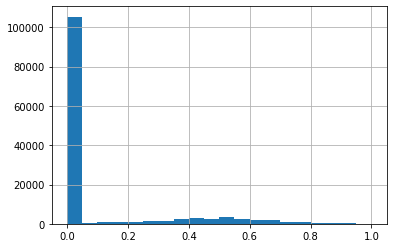

In [10]:
start = df["poi_start"]
end = df["poi_end"]
s_lengths = df["raw_address_tok"].apply(len)

mask = start >= 0
start = start[mask]
end = end[mask]
s_lengths = s_lengths[mask]

(start / (s_lengths - 1 + 1e-10)).hist(bins=20)

In [12]:
# Fraction of POI that starts at the beginning of the sentence
(start == 0).sum() / len(start)

0.796552428970498

<AxesSubplot:>

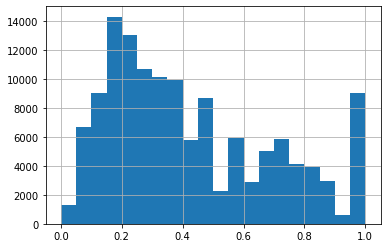

In [11]:
(end / (s_lengths - 1 + 1e-10)).hist(bins=20)

<AxesSubplot:>

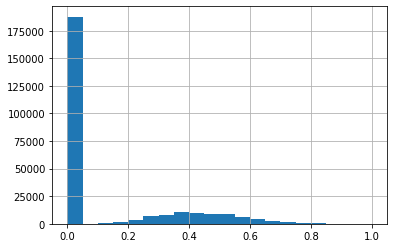

In [13]:
start = df["street_start"]
end = df["street_end"]
s_lengths = df["raw_address_tok"].apply(len)

mask = start >= 0
start = start[mask]
end = end[mask]
s_lengths = s_lengths[mask]

(start / (s_lengths - 1 + 1e-10)).hist(bins=20)

In [14]:
# Fraction of POI that starts at the beginning of the sentence
(start == 0).sum() / len(start)

0.7127445880213099

<AxesSubplot:>

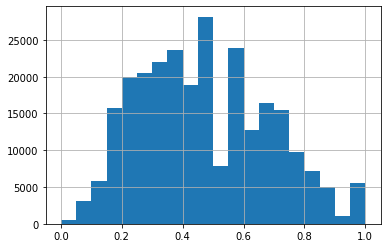

In [15]:
(end / (s_lengths - 1 + 1e-10)).hist(bins=20)

### Observations

1. The start index distributions are very similar. The end index distributions, however, are not.
2. There is a significant peak at start index 0 for both street and POI, indicating that a raw address is most likely to start with a street name or a person name, which is expected.
3. There is also a small peak at end index 1.0 (last token in the sentence), indicating that these are sometimes written at the end of the adress, which is also expected. This is especially applicable for POI (its peak is significant).

# 3. Stratified sampling

Based on the occurrences of POI and street (`0`: no POI, no street, `1`: no street, `2`: no POI, `3`: have both) and total lengths of the tokenize raw address.

In [1]:
import os
import math
import json

import pandas as pd

In [2]:
num_folds = 10
src_path = "data/processed/train_processed.json"
dest_dir = "data/processed/splits/"

In [3]:
with open(src_path, "r") as fin:
    df = json.load(fin)

df = pd.DataFrame.from_dict(df, orient="index")
print(len(df))
df.head(2)

300000


,raw_address,poi,street,raw_address_tok,poi_tok,street_tok,poi_start,poi_end,street_start,street_end
0,kedai kopi sidikalang palapa no 8 labuh baru t...,kedai kopi sidikalang,palapa,"[▁kedai, ▁kopi, ▁si, dika, lang, ▁pala, pa, ▁n...","[▁kedai, ▁kopi, ▁si, dika, lang]","[▁pala, pa]",0,4,5,6
1,"jalan b. kawi, no 18 rw 11 50261",,jalan b. kawi,"[▁jalan, ▁b, ▁, ., ▁ka, wi, ▁, ,, ▁no, ▁18, ▁r...",[],"[▁jalan, ▁b, ▁, ., ▁ka, wi]",-1,-1,0,5


In [4]:
df["raw_address_lengths"] = df["raw_address_tok"].apply(len)

street = (df["street_start"].to_numpy() != -1)
poi = (df["poi_start"].to_numpy() != -1) * 2
df["have_street_and_poi"] = street + poi

df.head(2)

,raw_address,poi,street,raw_address_tok,poi_tok,street_tok,poi_start,poi_end,street_start,street_end,raw_address_lengths,have_street_and_poi
0,kedai kopi sidikalang palapa no 8 labuh baru t...,kedai kopi sidikalang,palapa,"[▁kedai, ▁kopi, ▁si, dika, lang, ▁pala, pa, ▁n...","[▁kedai, ▁kopi, ▁si, dika, lang]","[▁pala, pa]",0,4,5,6,13,3
1,"jalan b. kawi, no 18 rw 11 50261",,jalan b. kawi,"[▁jalan, ▁b, ▁, ., ▁ka, wi, ▁, ,, ▁no, ▁18, ▁r...",[],"[▁jalan, ▁b, ▁, ., ▁ka, wi]",-1,-1,0,5,16,1


In [5]:
folds = [[] for _ in range(num_folds)]
df = df.sample(frac=1.0, random_state=136)

for (_, _), sub_df in df.groupby(["raw_address_lengths", "have_street_and_poi"]):
    size = math.ceil(len(sub_df) / num_folds)

    for i in range(num_folds):
        start = i * size
        end = min((i + 1) * size, len(sub_df))
        folds[i].append(sub_df.iloc[start:end])

folds = [pd.concat(fold, ignore_index=True) for fold in folds]
print([len(fold) for fold in folds])
folds[0].head(2)

[30102, 30078, 30068, 30061, 30059, 30052, 30039, 30026, 29997, 29518]


,raw_address,poi,street,raw_address_tok,poi_tok,street_tok,poi_start,poi_end,street_start,street_end,raw_address_lengths,have_street_and_poi
0,rata,,,[▁rata],[],[],-1,-1,-1,-1,1,0
1,protokol,,protokol,[▁protokol],[],[▁protokol],-1,-1,0,0,1,1


In [6]:
# Post process and save
save_path = os.path.join(dest_dir, "fold_{}.json")

for i, df_fold in enumerate(folds):
    df_fold = df_fold[["raw_address", "poi", "street", "raw_address_tok", 
                       "poi_tok", "street_tok", "poi_start", "poi_end", 
                       "street_start", "street_end"]]
    with open(save_path.format(i), "w") as fout:
        json.dump(df_fold.T.to_dict(), fout, indent=2)

# 4. Process test data

In [1]:
import re
import json

import pandas as pd
from tqdm import tqdm
from transformers import AutoTokenizer, AutoModelForTokenClassification

tqdm.pandas()

In [2]:
tokenizer = AutoTokenizer.from_pretrained("cahya/xlm-roberta-large-indonesian-NER")
patt = re.compile("((?<=.)(?![a-zA-Z0-9]))|((?<![a-zA-Z0-9])(?<=.)(?=.))")

df = pd.read_csv("data/orig/test.csv")
print(len(df))
df.head(3)

50000


,id,raw_address
0,0,"jalan haji abdul manaf, no 7"
1,1,"jalan damai vi, no 15 rt 1 rw 8 cipondoh makmur"
2,2,toko waris


In [3]:
def pre_tokenize(s):
    """Split punctuations, etc."""
    s_tokenized = patt.split(s)
    s_tokenized = list(
        filter(lambda x: x is not None and len(x) > 0 and not x.isspace(), 
               s_tokenized)
    )
    s = " ".join(s_tokenized)
    return s

def transforms(row):
    raw_address = row["raw_address"]
    raw_address_tokenized = tokenizer.tokenize(pre_tokenize(raw_address))

    return pd.Series({"raw_address": raw_address,
                      "raw_address_tok": raw_address_tokenized})

In [4]:
df_processed = df.progress_apply(transforms, axis=1)
print(len(df_processed))
df_processed.head(2)

100%|██████████| 50000/50000 [00:21<00:00, 2361.53it/s]

50000


,raw_address,raw_address_tok
0,"jalan haji abdul manaf, no 7","[▁jalan, ▁haji, ▁ab, dul, ▁man, af, ▁, ,, ▁no,..."
1,"jalan damai vi, no 15 rt 1 rw 8 cipondoh makmur","[▁jalan, ▁da, mai, ▁vi, ▁, ,, ▁no, ▁15, ▁, rt,..."


In [5]:
df_processed = df_processed.T.to_dict()
print(len(df_processed))
df_processed[0]

50000


{'raw_address': 'jalan haji abdul manaf, no 7',
 'raw_address_tok': ['▁jalan',
  '▁haji',
  '▁ab',
  'dul',
  '▁man',
  'af',
  '▁',
  ',',
  '▁no',
  '▁7']}

In [6]:
with open("data/processed/test_processed.json", "w") as fout:
    json.dump(df_processed, fout, indent=2)